In [50]:
#!pip install validators
#!pip install torch torchvision torchaudio
#!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
#%pip install torchinfo

In [51]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd
import gc
import traceback
import random
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
import sklearn.metrics as sm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc   
from sklearn.metrics import classification_report, balanced_accuracy_score

import seaborn as sns
from itertools import cycle
from scipy import interp

warnings.filterwarnings('ignore')
%matplotlib inline

torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [52]:
# Number of workers for dataloader
workers = 8

# Batch size during training
BATCH_SIZE = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
IMAGE_SIZE = 64

# Number of training epochs
NUM_EPOCHS = 50

# Learning rate for optimizers
lr = 0.1

# Beta1 hyperparam for optimizers
beta1 = 0.9

# Beta2 hyperparam for optimizers
beta2 = 0.999


In [53]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

In [54]:
import argparse
import os

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet50')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [55]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [56]:
#DATADIR = "BeeMachine_quarter"
DATADIR = "BeeMachine_Full"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_bohemicus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_cockerelli", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_franklini", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_jonellus", "Bombus_kirbiellus", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_natvigi", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus", "Bombus_polaris","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_suckleyi", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", "Bombus_variabilis",
             "Bombus_vosnesenskii"]

Import Data

In [57]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [58]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
                                    std=[0.2403, 0.2280, 0.2248])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]),
}


def load_dataset(transformer):        
    #Load image
    dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
    return dataset


Separate data to train and validation dataset

In [59]:
bee_dataset = load_dataset(data_transforms['train'])

num_classes=len(bee_dataset.targets)
train_indices, val_indices = train_test_split(list(range(num_classes)), test_size=0.2, stratify=bee_dataset.targets)
train_dataset = torch.utils.data.Subset(bee_dataset, train_indices)
val_dataset = torch.utils.data.Subset(bee_dataset, val_indices)
#train_dataset = MyDataset(train_dataset, data_transforms['train'])
#val_dataset = MyDataset(val_dataset, data_transforms['validation'])
resnet50.fc = nn.Sequential(
               nn.Linear(2048, IMAGE_SIZE),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(IMAGE_SIZE, 45),
               nn.Softmax()).to(device) 
torch.autograd.set_detect_anomaly(True)               

Create DataLoader

In [60]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)
actuals, probabilities, predictions = [], [], []
test_accs, confusion_mtxes = [], []
test_targets, test_preds = [], []
final_y_preds, final_y_trues, final_y_scores = [], [], []
#labels = [label for _, label in val_data_loader.dataset]
#classe_labels, counts = np.unique(labels, return_counts=True)

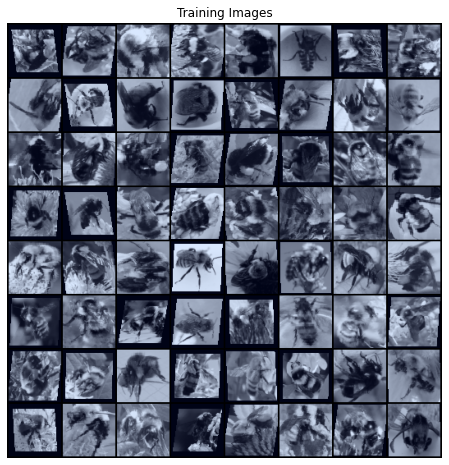

In [61]:
# Plot some training images
real_batch = next(iter(train_data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [62]:
weights = class_weight.compute_class_weight('balanced', np.unique(bee_dataset.targets), bee_dataset.targets)
class_weights=torch.tensor(weights,dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)


In [63]:
def process(model, train_loader, test_loader, epochs, lr, criterion):
    
    optimizer_new = torch.optim.SGD(model.parameters(), lr,
                            momentum=beta1, 
                            weight_decay=1e-4)

    # train & test process
    def train(train_loader, current_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total=0
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer_new.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer_new.step()
            
            running_loss += loss.item()
            _,pred = torch.max(output, dim=1)
            correct += torch.sum(pred==target).item()
            total += target.size(0)

            #print('\rTraining %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)
            if (batch_idx) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} \n' 
                    .format(current_epoch, num_epochs, batch_idx, len(train_loader), loss.item()))
            train_acc.append(100 * correct / total)
            train_loss.append(running_loss/total_step)         
       

    def test(test_loader):
        model.eval()
        correct = 0
        total = 0
        y_targets, y_preds, y_probs = [], [], []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                actuals.extend(pred.eq(target.view_as(pred)).cpu().long())
                probabilities.extend(np.exp(output.cpu()[:, len(CATEGORIES)-1]))

                probs = torch.nn.functional.softmax(output, dim=1)
                
                total += target.size(0)
                y_targets.append(target.cpu().numpy())
                y_preds.append(pred.cpu().numpy())
                y_probs.append(probs.detach().cpu().numpy())
                
                #print(f'\ntest-acc: {(100 * correct/total):.4f}')
                test_acc = 100. * correct / total
                test_accs.append(test_acc)
            #confusion_mtx = sm.confusion_matrix(y_targets, y_preds)
            confusion_mtx = []
            y_preds = np.concatenate(y_preds)
            y_targets = np.concatenate(y_targets)
            y_probs = np.concatenate(y_probs)

        return confusion_mtx, y_targets, y_preds, y_probs
    
        
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch} \n")
        train(train_loader, epoch, epochs)
        confusion_mtx,  final_y_pred, final_y_true, final_y_score = test(test_loader)
        #confusion_mtxes.append(confusion_mtx)        
        print('\nBest test acc = %2.4f%%' % max(test_accs), flush=True)
        final_y_preds.append(final_y_pred)
        final_y_trues.append(final_y_true)
        final_y_scores.append(final_y_score)
    
    #vis(test_accs, confusion_mtxes, classe_labels)
    #printMatries(targets, preds)
    

In [64]:
try:
    process(resnet50, train_data_loader, val_data_loader, NUM_EPOCHS, lr, criterion)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Epoch 1 

Epoch [1/50], Step [0/1310], Loss: 3.8060 

Epoch [1/50], Step [100/1310], Loss: 3.8010 

Epoch [1/50], Step [200/1310], Loss: 3.8018 

Epoch [1/50], Step [300/1310], Loss: 3.8084 

Epoch [1/50], Step [400/1310], Loss: 3.8297 

Epoch [1/50], Step [500/1310], Loss: 3.7940 

Epoch [1/50], Step [600/1310], Loss: 3.8041 

Epoch [1/50], Step [700/1310], Loss: 3.7860 

Epoch [1/50], Step [800/1310], Loss: 3.7861 

Epoch [1/50], Step [900/1310], Loss: 3.7528 

Epoch [1/50], Step [1000/1310], Loss: 3.7897 

Epoch [1/50], Step [1100/1310], Loss: 3.8195 

Epoch [1/50], Step [1200/1310], Loss: 3.7977 

Epoch [1/50], Step [1300/1310], Loss: 3.8040 


Best test acc = 15.6250%
Epoch 2 

Epoch [2/50], Step [0/1310], Loss: 3.8044 

Epoch [2/50], Step [100/1310], Loss: 3.7847 

Epoch [2/50], Step [200/1310], Loss: 3.7588 

Epoch [2/50], Step [300/1310], Loss: 3.7891 

Epoch [2/50], Step [400/1310], Loss: 3.7749 

Epoch [2/50], Step [500/1310], Loss: 3.7940 

Epoch [2/50], Step [600/1310], Los

In [65]:
def printMatries(labels, preds):
     print('weighted Avg F1 Score: {:.4f}'.format(f1_score(labels, preds, average='weighted')))
     print('weighted Avg Precision: {:.4f}'.format(precision_score(labels, preds, average='weighted')))
     print('weighted Avg Recall: {:.4f}'.format(recall_score(labels, preds, average='weighted')))
     print('Avg Accuracy: {:.4f}'.format(accuracy_score(labels, preds)))
     print('Balanced Avg Accuracy: {:.4f}'.format(balanced_accuracy_score(labels, preds)))
     


In [66]:
# calculate avg of reports
true_avg = [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_trues)]
pred_avg =  [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_preds)]

print(classification_report(true_avg, pred_avg, target_names=CATEGORIES))
printMatries(true_avg, pred_avg)

                              precision    recall  f1-score   support

              Bombus_affinis       0.00      0.00      0.00         0
            Bombus_appositus       0.00      0.00      0.00         1
            Bombus_auricomus       0.00      0.00      0.00        16
             Bombus_bifarius       0.00      0.00      0.00        60
          Bombus_bimaculatus       0.03      0.26      0.05       164
            Bombus_bohemicus       0.00      0.00      0.00       272
             Bombus_borealis       0.01      0.01      0.01       425
          Bombus_caliginosus       0.00      0.00      0.00       544
            Bombus_centralis       0.05      0.02      0.03       693
             Bombus_citrinus       0.03      0.01      0.02       672
           Bombus_cockerelli       0.00      0.00      0.00       649
             Bombus_crotchii       0.01      0.00      0.00       596
            Bombus_cryptarum       0.01      0.00      0.00       635
   Bombus_fernaldae

In [67]:
def vis(test_accs, confusion_mtx, figsize=(20, 8)):
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    #vis(test_accs, confusion_mtxes, labels)
    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(confusion_mtx, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Display the visualization of the Confusion Matrix.
    plt.show()

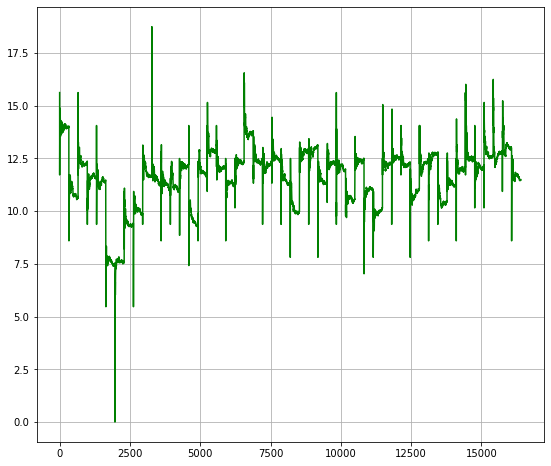

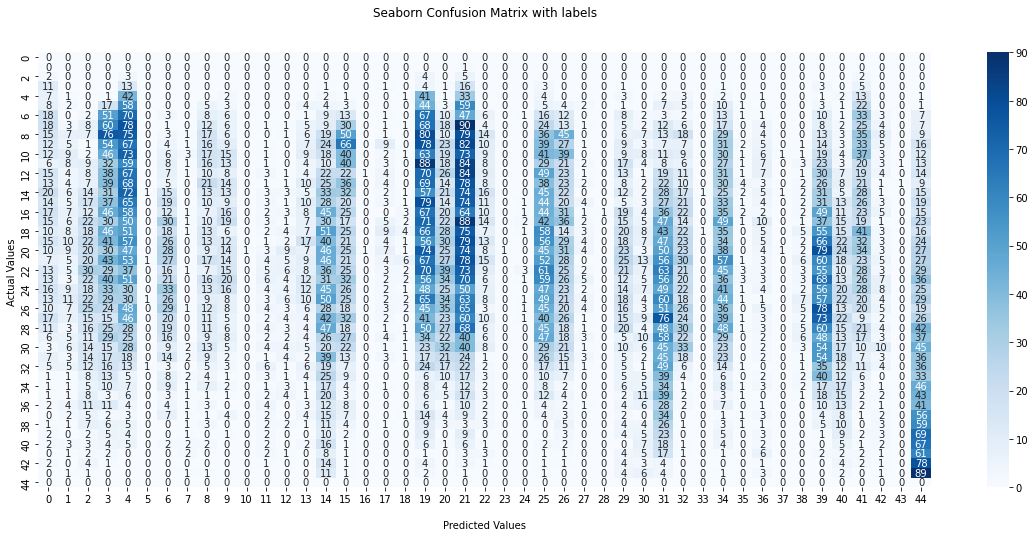

In [68]:
confusion_mtx = sm.confusion_matrix(true_avg, pred_avg)
vis(test_accs, confusion_mtx)


In [69]:
def displayROC_Curve(y_test, y_score, figsize = (8, 6)):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

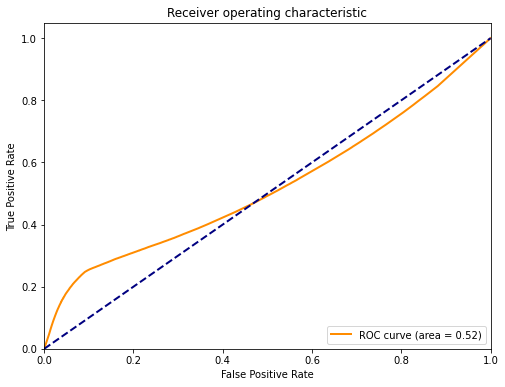

In [70]:
actuals_tmp = [i.detach().cpu().numpy() for i in actuals]
probabilities_tmp = [i.item() for i in probabilities]
displayROC_Curve(actuals_tmp, probabilities_tmp)


In [71]:
# print('Dataset: %d training samples & %d testing samples\n' % (
#     len(train_data_loader.dataset), len(val_data_loader.dataset)))
 
# print('Distribution of classes in dataset:')
# fig, ax = plt.subplots()
# fig = plt.figure(figsize=(20,10))
# labels = [label for _, label in train_dataset]
# classe_labels, counts = np.unique(labels, return_counts=True)
# ax.bar(classe_labels, counts)
# ax.set_xticks(classe_labels)
# plt.show()

Save Model

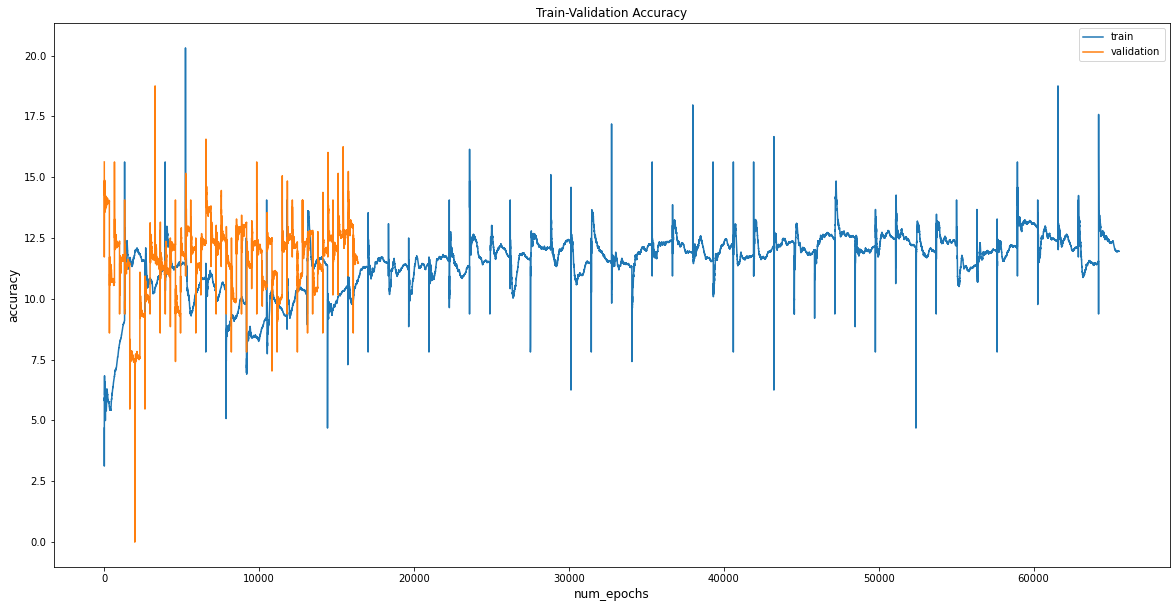

In [72]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(test_accs, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

## External Classifier DCGAN

In [73]:

os.makedirs("images", exist_ok=True)

LEARNING_RATE = 3e-4  # could also use two lrs, one for gen and one for disc
CHANNELS_IMG = 3
NOISE_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
G_losses = []
D_losses = []
cuda = True if torch.cuda.is_available() else False
resnet50_gan = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
resnet50_gan.to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [74]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, (nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [75]:
# Initialize generator and discriminator
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion_gan = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

resnet50_gan.fc = nn.Sequential(
               nn.Linear(2048, IMAGE_SIZE),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(IMAGE_SIZE, 45),
               nn.Softmax()).to(device) 

optimizer = optim.SGD(resnet50_gan.fc.parameters(), lr=lr, momentum=beta1)
train_loss = []
train_acc = []
actuals, probabilities, predictions = [], [], []
test_accs, confusion_mtxes = [], []
test_targets, test_preds = [], []
final_y_preds, final_y_trues, final_y_scores = [], [], []
total_step = len(train_dataset)


In [76]:
def training_cgan(model, n_epochs, train_data_loader, val_data_loader, opt_gen, opt_disc, model_criterion, model_optimizer, train_loss, train_acc, total_step):
    # ----------
    #  Training
    # ----------

    gen.train()
    disc.train()
    model.train()

    def train(train_loader, current_epoch):
        realClassifierLoss = None
        fakeClassifierLoss = None
        correct = 0
        total=0
        # Target labels not needed! <3 unsupervised
        for batch_idx, (real, labels) in enumerate(train_loader):
            real = real.to(device)
            labels = labels.to(device)


            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc.zero_grad()
            # train discriminator on real images
            disc_real = disc(real).reshape(-1)
            loss_disc_real = criterion_gan(disc_real, torch.ones_like(disc_real))
            loss_disc_real.backward(retain_graph = True) 

            # train discriminator on fake images
            disc_fake = disc(fake.detach()).reshape(-1)
            loss_disc_fake = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            loss_disc_fake.backward(retain_graph = True) 

            loss_disc = (loss_disc_real + loss_disc_fake)
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            gen.zero_grad()
            disc_fake = disc(fake).reshape(-1)
            loss_gen = criterion_gan(disc_fake , torch.ones_like(disc_fake))
            loss_gen.backward(retain_graph = True)
            opt_gen.step()

            # train classifier on real data
            preds = model(real)
            realClassifierLoss = model_criterion(preds, labels)
            realClassifierLoss.backward(retain_graph=True)

            model_optimizer.step()
            model_optimizer.zero_grad()

            _,pred = torch.max(preds, dim=1)
            correct += torch.sum(pred==labels).item()
            total += labels.size(0)

            # update the classifer on fake data
            predictionsFake = model(fake)
            # get a tensor of the labels that are most likely according to model
            predictedLabels = torch.argmax(predictionsFake, 1) # -> [0 , 5, 9, 3, ...]
            confidenceThresh = .7 # for example

            # psuedo labeling threshold
            probs = F.softmax(predictionsFake, dim=1)
            mostLikelyProbs = np.asarray([probs[i, predictedLabels[i]].item() for  i in range(len(probs))])
            toKeep = mostLikelyProbs > confidenceThresh
            if sum(toKeep) != 0:
                fakeClassifierLoss = model_criterion(predictionsFake[toKeep], predictedLabels[toKeep])
                fakeClassifierLoss.backward()

            model_optimizer.step()

            # reset the gradients
            opt_disc.zero_grad()
            opt_gen.zero_grad()
            model_optimizer.zero_grad()

            # Print losses occasionally and print to tensorboard
            if batch_idx % 50 == 0:
                print(
                    f"Epoch [{current_epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                    Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
                )
                print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
            # Save Losses for plotting later
            G_losses.append(loss_gen.item())
            D_losses.append(loss_disc.item())
        
            train_acc.append(100 * correct / total)
            train_loss.append(realClassifierLoss.item()/total_step)


    def test(test_loader):
            model.eval()
            correct = 0
            total = 0
            y_targets, y_preds, y_probs = [], [], []
            
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                actuals.extend(pred.eq(target.view_as(pred)).cpu().long())
                probabilities.extend(np.exp(output.detach().cpu()[:, len(CATEGORIES)-1]))

                probs = torch.nn.functional.softmax(output, dim=1)
                
                total += target.size(0)
                y_targets.append(target.cpu().numpy())
                y_preds.append(pred.cpu().numpy())
                y_probs.append(probs.detach().cpu().numpy())
                
                #print(f'\ntest-acc: {(100 * correct/total):.4f}')
                test_acc = 100. * correct / total
                test_accs.append(test_acc)
            #confusion_mtx = sm.confusion_matrix(y_targets, y_preds)
            confusion_mtx = []
            y_preds = np.concatenate(y_preds)
            y_targets = np.concatenate(y_targets)
            y_probs = np.concatenate(y_probs)

            return confusion_mtx, y_targets, y_preds, y_probs

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch} \n")
        train(train_data_loader, epoch)
        confusion_mtx,  final_y_pred, final_y_true, final_y_score = test(val_data_loader)
        #confusion_mtxes.append(confusion_mtx)        
        print('\nBest test acc = %2.4f%%' % max(test_accs), flush=True)
        final_y_preds.append(final_y_pred)
        final_y_trues.append(final_y_true)
        final_y_scores.append(final_y_score)
        

            

In [77]:
training_cgan(resnet50_gan, NUM_EPOCHS, train_data_loader, val_data_loader, opt_gen, opt_disc, criterion, optimizer, train_loss, train_acc, total_step)

Epoch 1 

Epoch [1/50] Batch 0/1310                     Loss D: 1.5979, loss G: 8.0059

train-loss: nan, train-acc: 0.0000
Epoch [1/50] Batch 50/1310                     Loss D: 0.8589, loss G: 21.5383

train-loss: 0.0000, train-acc: 2.2365
Epoch [1/50] Batch 100/1310                     Loss D: 0.5822, loss G: 3.9990

train-loss: 0.0000, train-acc: 1.3614
Epoch [1/50] Batch 150/1310                     Loss D: 0.3698, loss G: 2.9137

train-loss: 0.0000, train-acc: 1.0244
Epoch [1/50] Batch 200/1310                     Loss D: 0.8468, loss G: 2.6057

train-loss: 0.0000, train-acc: 0.8318
Epoch [1/50] Batch 250/1310                     Loss D: 1.2391, loss G: 2.2790

train-loss: 0.0000, train-acc: 0.7097
Epoch [1/50] Batch 300/1310                     Loss D: 1.3570, loss G: 4.6478

train-loss: 0.0000, train-acc: 0.6437
Epoch [1/50] Batch 350/1310                     Loss D: 0.5352, loss G: 4.1134

train-loss: 0.0000, train-acc: 0.6054
Epoch [1/50] Batch 400/1310                     Los

In [78]:
# calculate avg of reports
true_avg = [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_trues)]
pred_avg = [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_preds)]

print(classification_report(true_avg, pred_avg, target_names=CATEGORIES))
printMatries(true_avg, pred_avg)

                              precision    recall  f1-score   support

              Bombus_affinis       0.00      0.00      0.00         0
            Bombus_appositus       0.00      0.00      0.00         0
            Bombus_auricomus       0.00      0.00      0.00         0
             Bombus_bifarius       0.00      0.00      0.00         0
          Bombus_bimaculatus       0.00      0.00      0.00         0
            Bombus_bohemicus       0.00      0.00      0.00         0
             Bombus_borealis       0.00      0.00      0.00         0
          Bombus_caliginosus       0.00      0.00      0.00         0
            Bombus_centralis       0.00      0.00      0.00         0
             Bombus_citrinus       0.00      0.00      0.00         0
           Bombus_cockerelli       0.00      0.00      0.00         0
             Bombus_crotchii       0.00      0.00      0.00         0
            Bombus_cryptarum       0.00      0.00      0.00         0
   Bombus_fernaldae

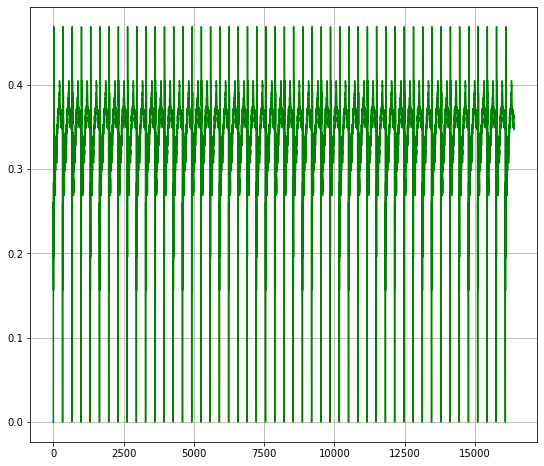

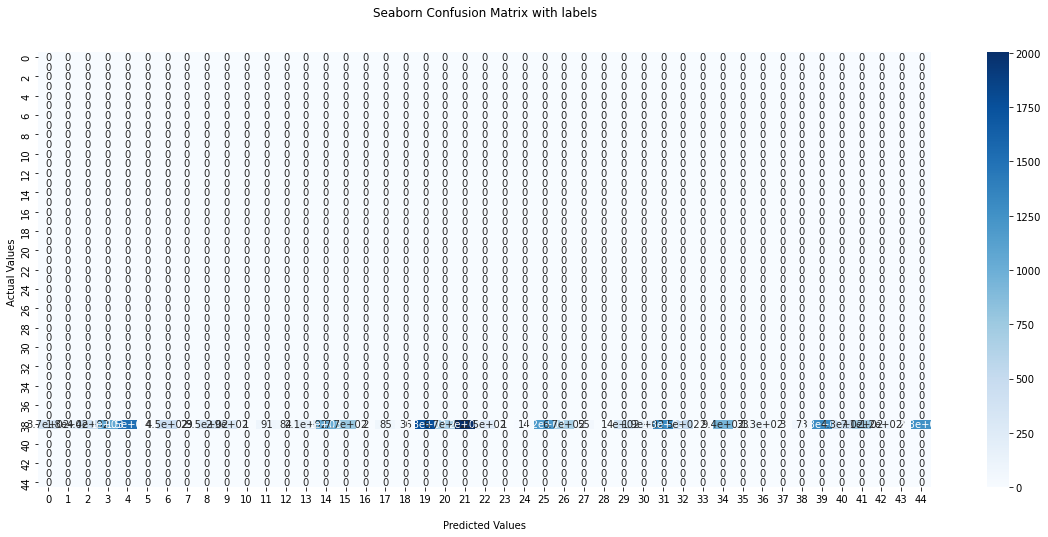

In [79]:
confusion_mtx = sm.confusion_matrix(true_avg, pred_avg)
vis(test_accs, confusion_mtx)

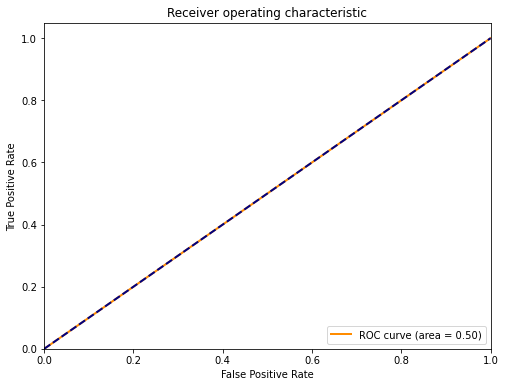

In [80]:
actuals_tmp = [i.detach().cpu().numpy() for i in actuals]
probabilities_tmp = [i.item() for i in probabilities]
displayROC_Curve(actuals_tmp, probabilities_tmp)

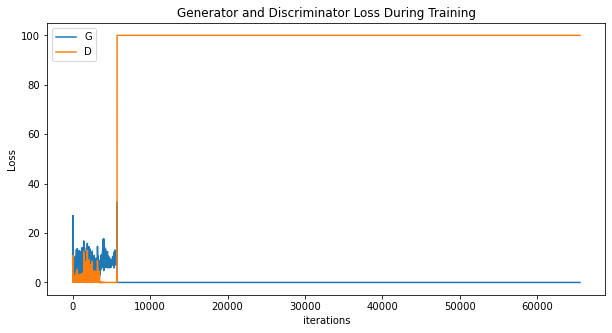

In [81]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



## OVER SAMPLEING ## 



In [82]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [83]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader

actuals, probabilities, predictions = [], [], []
test_accs, confusion_mtxes = [], []
test_targets, test_preds = [], []
final_y_preds, final_y_trues, final_y_scores = [], [], []

In [84]:
Oversample = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
Oversample.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [85]:
train_loader = train_data_loader
test_loader = val_data_loader

Dataset:   104770  training samples & 20954  testing samples

Distribution of classes in dataset:


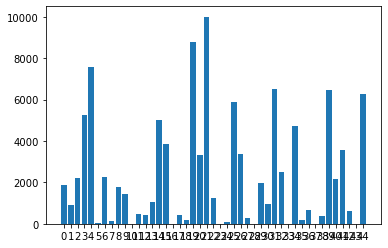

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
        
#!pip install seaborn
import seaborn as sns

print('Dataset:   %d  training samples & %d  testing samples\n' % (
   len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

In [87]:
criterion = nn.CrossEntropyLoss().cuda()

In [88]:
process(Oversample, train_loader, test_loader, NUM_EPOCHS, lr, criterion)

Epoch 1 

Epoch [1/50], Step [0/410], Loss: 12.5747 

Epoch [1/50], Step [100/410], Loss: 2.9815 

Epoch [1/50], Step [200/410], Loss: 2.6849 

Epoch [1/50], Step [300/410], Loss: 2.3419 

Epoch [1/50], Step [400/410], Loss: 2.1453 


Best test acc = 17.1875%
Epoch 2 

Epoch [2/50], Step [0/410], Loss: 2.4701 

Epoch [2/50], Step [100/410], Loss: 2.3323 

Epoch [2/50], Step [200/410], Loss: 2.2232 

Epoch [2/50], Step [300/410], Loss: 2.2220 

Epoch [2/50], Step [400/410], Loss: 2.0246 


Best test acc = 20.3125%
Epoch 3 

Epoch [3/50], Step [0/410], Loss: 1.8545 

Epoch [3/50], Step [100/410], Loss: 2.0411 

Epoch [3/50], Step [200/410], Loss: 1.7460 

Epoch [3/50], Step [300/410], Loss: 1.8261 

Epoch [3/50], Step [400/410], Loss: 1.8470 


Best test acc = 22.1101%
Epoch 4 

Epoch [4/50], Step [0/410], Loss: 1.6655 

Epoch [4/50], Step [100/410], Loss: 1.6176 

Epoch [4/50], Step [200/410], Loss: 1.6693 

Epoch [4/50], Step [300/410], Loss: 1.4881 

Epoch [4/50], Step [400/410], Loss

In [89]:
# calculate avg of reports
true_avg = [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_trues)]
pred_avg =  [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_preds)]

print(classification_report(true_avg, pred_avg, target_names=CATEGORIES))
printMatries(true_avg, pred_avg)

                              precision    recall  f1-score   support

              Bombus_affinis       0.04      1.00      0.08        16
            Bombus_appositus       0.10      0.43      0.16        42
            Bombus_auricomus       0.01      0.06      0.02        95
             Bombus_bifarius       0.03      0.19      0.05       165
          Bombus_bimaculatus       0.01      0.09      0.02       204
            Bombus_bohemicus       1.00      0.01      0.03       282
             Bombus_borealis       0.10      0.17      0.13       273
          Bombus_caliginosus       0.45      0.04      0.07       370
            Bombus_centralis       0.11      0.11      0.11       364
             Bombus_citrinus       0.11      0.07      0.09       434
           Bombus_cockerelli       1.00      0.00      0.00       400
             Bombus_crotchii       0.44      0.09      0.15       456
            Bombus_cryptarum       0.49      0.08      0.14       523
   Bombus_fernaldae

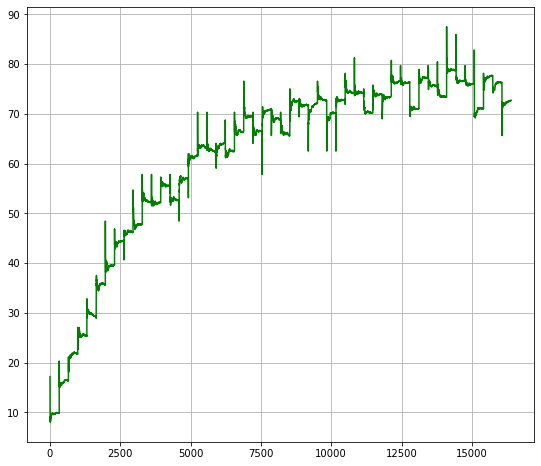

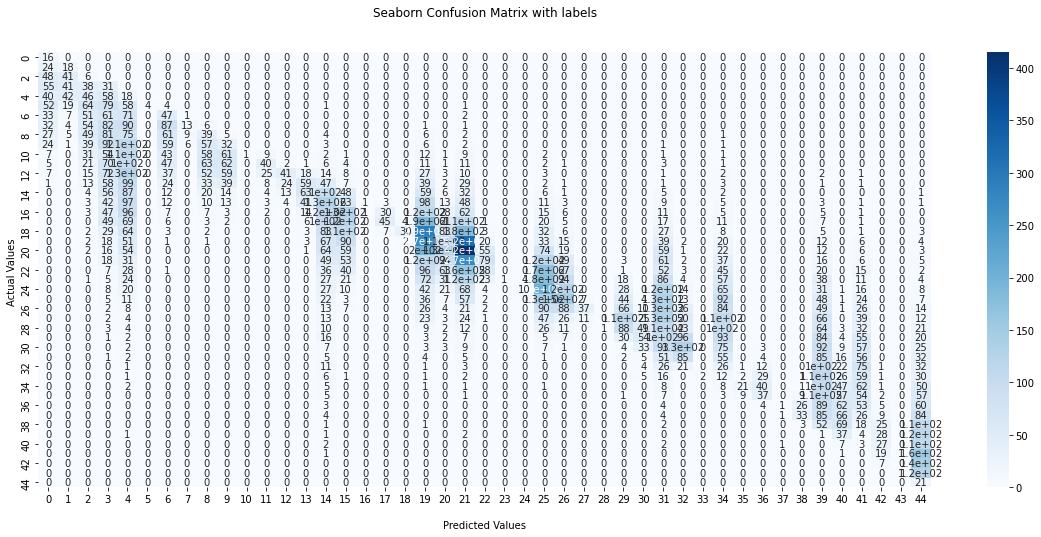

In [90]:
confusion_mtx = sm.confusion_matrix(true_avg, pred_avg)
vis(test_accs, confusion_mtx)

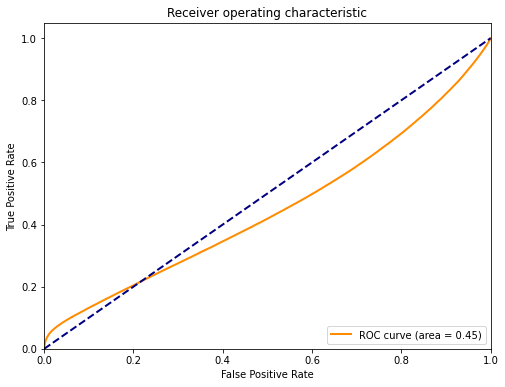

In [91]:
actuals_tmp = [i.detach().cpu().numpy() for i in actuals]
probabilities_tmp = [i.item() for i in probabilities]
displayROC_Curve(actuals_tmp, probabilities_tmp)

## UNDER SAMPLEING

In [92]:
under_sample = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
under_sample.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [93]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 31848)                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader
actuals, probabilities, predictions = [], [], []
test_accs, confusion_mtxes = [], []
test_targets, test_preds = [], []
final_y_preds, final_y_trues, final_y_scores = [], [], []

In [ ]:
print('Dataset:   %d  training samples & %d  testing samples\n' % (
   len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

In [94]:
process(under_sample, train_loader, test_loader, NUM_EPOCHS, lr, criterion)


Epoch 1 

Epoch [1/50], Step [0/125], Loss: 12.4618 

Epoch [1/50], Step [100/125], Loss: 2.9122 


Best test acc = 7.8125%
Epoch 2 

Epoch [2/50], Step [0/125], Loss: 2.9212 

Epoch [2/50], Step [100/125], Loss: 2.6241 


Best test acc = 15.6250%
Epoch 3 

Epoch [3/50], Step [0/125], Loss: 2.5563 

Epoch [3/50], Step [100/125], Loss: 2.5156 


Best test acc = 15.6250%
Epoch 4 

Epoch [4/50], Step [0/125], Loss: 2.3695 

Epoch [4/50], Step [100/125], Loss: 2.3982 


Best test acc = 15.6250%
Epoch 5 

Epoch [5/50], Step [0/125], Loss: 2.3549 

Epoch [5/50], Step [100/125], Loss: 2.4163 


Best test acc = 15.6250%
Epoch 6 

Epoch [6/50], Step [0/125], Loss: 2.2361 

Epoch [6/50], Step [100/125], Loss: 1.8483 


Best test acc = 17.1875%
Epoch 7 

Epoch [7/50], Step [0/125], Loss: 2.2019 

Epoch [7/50], Step [100/125], Loss: 1.9293 


Best test acc = 17.1875%
Epoch 8 

Epoch [8/50], Step [0/125], Loss: 1.9989 

Epoch [8/50], Step [100/125], Loss: 1.8476 


Best test acc = 23.4375%
Epoch 9 

In [95]:
# calculate avg of reports
true_avg = [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_trues)]
pred_avg =  [int(sum(sub_list) / len(sub_list)) for sub_list in zip(*final_y_preds)]

print(classification_report(true_avg, pred_avg, target_names=CATEGORIES))
printMatries(true_avg, pred_avg)

                              precision    recall  f1-score   support

              Bombus_affinis       0.00      0.00      0.00         0
            Bombus_appositus       0.00      0.00      0.00         3
            Bombus_auricomus       0.00      0.12      0.00         8
             Bombus_bifarius       0.00      0.16      0.01        25
          Bombus_bimaculatus       0.00      0.02      0.00        52
            Bombus_bohemicus       0.50      0.02      0.04        91
             Bombus_borealis       0.02      0.07      0.03       121
          Bombus_caliginosus       0.21      0.03      0.06       176
            Bombus_centralis       0.02      0.03      0.03       259
             Bombus_citrinus       0.03      0.03      0.03       279
           Bombus_cockerelli       1.00      0.00      0.01       337
             Bombus_crotchii       0.12      0.03      0.05       386
            Bombus_cryptarum       0.08      0.01      0.02       509
   Bombus_fernaldae

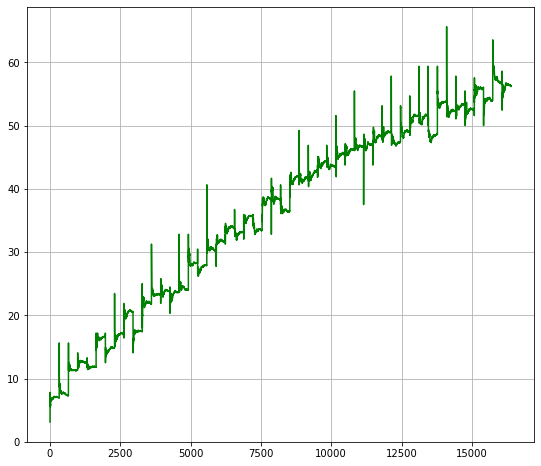

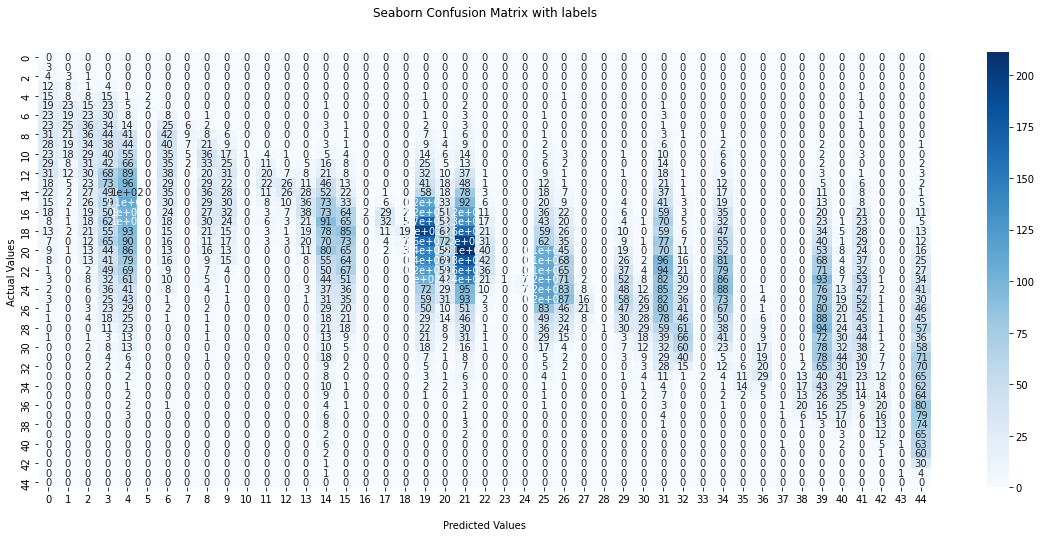

In [96]:
confusion_mtx = sm.confusion_matrix(true_avg, pred_avg)
vis(test_accs, confusion_mtx)

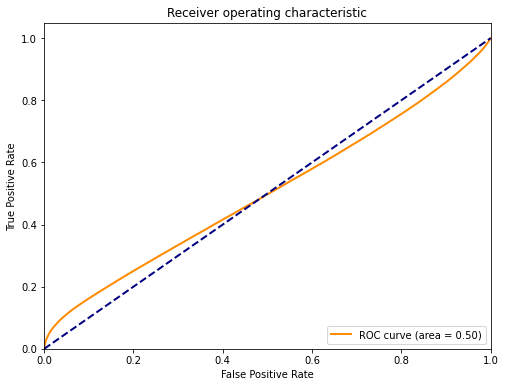

In [97]:
actuals_tmp = [i.detach().cpu().numpy() for i in actuals]
probabilities_tmp = [i.item() for i in probabilities]
displayROC_Curve(actuals_tmp, probabilities_tmp)